<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Jupyter%20Notebook%20Scripts/Rabi_Oscillation_Visualization_for_Excited_State_Probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [2]:
# @title Install dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    %pip -q install pyvista pythreejs trame
print('Environment ready. IN_COLAB =', IN_COLAB)


Environment ready. IN_COLAB = True


In [3]:
# @title Controls & imports (PEP 8 with docstrings and type hints)
from __future__ import annotations
import math
from typing import Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

try:
    import pyvista as pv  # optional; only for 3D interactive
    PV_AVAILABLE = True
except Exception:
    PV_AVAILABLE = False

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.grid'] = False

# ---------- Control knobs ----------
F0_GHZ: float = 5.000        # Qubit transition freq f0 [GHz]
OMEGA_ONRESONANCE_MHZ: float = 20.0  # Ω/2π on-resonance [MHz]
FREQ_MIN_GHZ: float = 4.90   # Sweep min f [GHz]
FREQ_MAX_GHZ: float = 5.10   # Sweep max f [GHz]
N_FREQ: int = 401            # # of frequency points
DUR_MIN_NS: float = 0.0      # Sweep min duration τ [ns]
DUR_MAX_NS: float = 200.0    # Sweep max duration τ [ns]
N_DUR: int = 401             # # of duration points
T2STAR_NS: Optional[float] = 500.0  # None to disable exp(-τ/T2*)

# Exports
EXPORT_DIR = '.'
CSV_OUT = f"{EXPORT_DIR}/rabi_grid_freq_duration.csv"
PNG_HEATMAP = f"{EXPORT_DIR}/rabi_heatmap_2d.png"
PNG_SURFACE = f"{EXPORT_DIR}/rabi_surface_3d_matplotlib.png"
PNG_PYVISTA = f"{EXPORT_DIR}/rabi_surface_3d_pyvista.png"  # requires PV_AVAILABLE

print('Controls loaded.')


Controls loaded.


In [4]:
def rabi_probability(
    f_ghz: np.ndarray,
    tau_ns: np.ndarray,
    f0_ghz: float,
    omega_onres_mhz: float,
    t2star_ns: Optional[float] = None,
) -> np.ndarray:
    """Excited-state probability on a 2D grid (f, τ), under RWA.

    Args:
        f_ghz: 1D array of drive frequencies [GHz].
        tau_ns: 1D array of pulse durations [ns].
        f0_ghz: Qubit frequency on resonance [GHz].
        omega_onres_mhz: On-resonance Rabi rate Ω/2π [MHz].
        t2star_ns: Optional T2* [ns]; multiplies exp(−τ/T2*).

    Returns:
        2D array P_e with shape (len(tau_ns), len(f_ghz)).
    """
    two_pi = 2.0 * math.pi
    f = f_ghz * 1e9
    f0 = f0_ghz * 1e9
    tau = tau_ns * 1e-9
    omega = two_pi * omega_onres_mhz * 1e6  # rad/s

    F, TAU = np.meshgrid(f, tau, indexing='xy')
    Delta = two_pi * (F - f0)               # rad/s
    Omega_R = np.sqrt(omega**2 + Delta**2)

    with np.errstate(divide='ignore', invalid='ignore'):
        amp = (omega / Omega_R) ** 2
        phase = 0.5 * Omega_R * TAU
        Pe = amp * np.sin(phase) ** 2

    if t2star_ns is not None and t2star_ns > 0.0:
        decay = np.exp(-TAU / (t2star_ns * 1e-9))
        Pe = Pe * decay

    return np.clip(Pe, 0.0, 1.0)


In [5]:
freq_ghz = np.linspace(FREQ_MIN_GHZ, FREQ_MAX_GHZ, N_FREQ)
dur_ns = np.linspace(DUR_MIN_NS, DUR_MAX_NS, N_DUR)
Pe = rabi_probability(freq_ghz, dur_ns, F0_GHZ, OMEGA_ONRESONANCE_MHZ, T2STAR_NS)
print('Grid shape (τ × f):', Pe.shape)


Grid shape (τ × f): (401, 401)


In [6]:
controls_table = pd.DataFrame(
    [
        ['f0 (GHz)', F0_GHZ],
        ['Ω/2π on-res (MHz)', OMEGA_ONRESONANCE_MHZ],
        ['f sweep min (GHz)', FREQ_MIN_GHZ],
        ['f sweep max (GHz)', FREQ_MAX_GHZ],
        ['N_f', N_FREQ],
        ['τ sweep min (ns)', DUR_MIN_NS],
        ['τ sweep max (ns)', DUR_MAX_NS],
        ['N_τ', N_DUR],
        ['T2* (ns; None=off)', T2STAR_NS],
    ],
    columns=['Parameter', 'Value']
)
controls_table


,Parameter,Value
0,f0 (GHz),5.0
1,Ω/2π on-res (MHz),20.0
2,f sweep min (GHz),4.9
3,f sweep max (GHz),5.1
4,N_f,401.0
5,τ sweep min (ns),0.0
6,τ sweep max (ns),200.0
7,N_τ,401.0
8,T2* (ns; None=off),500.0


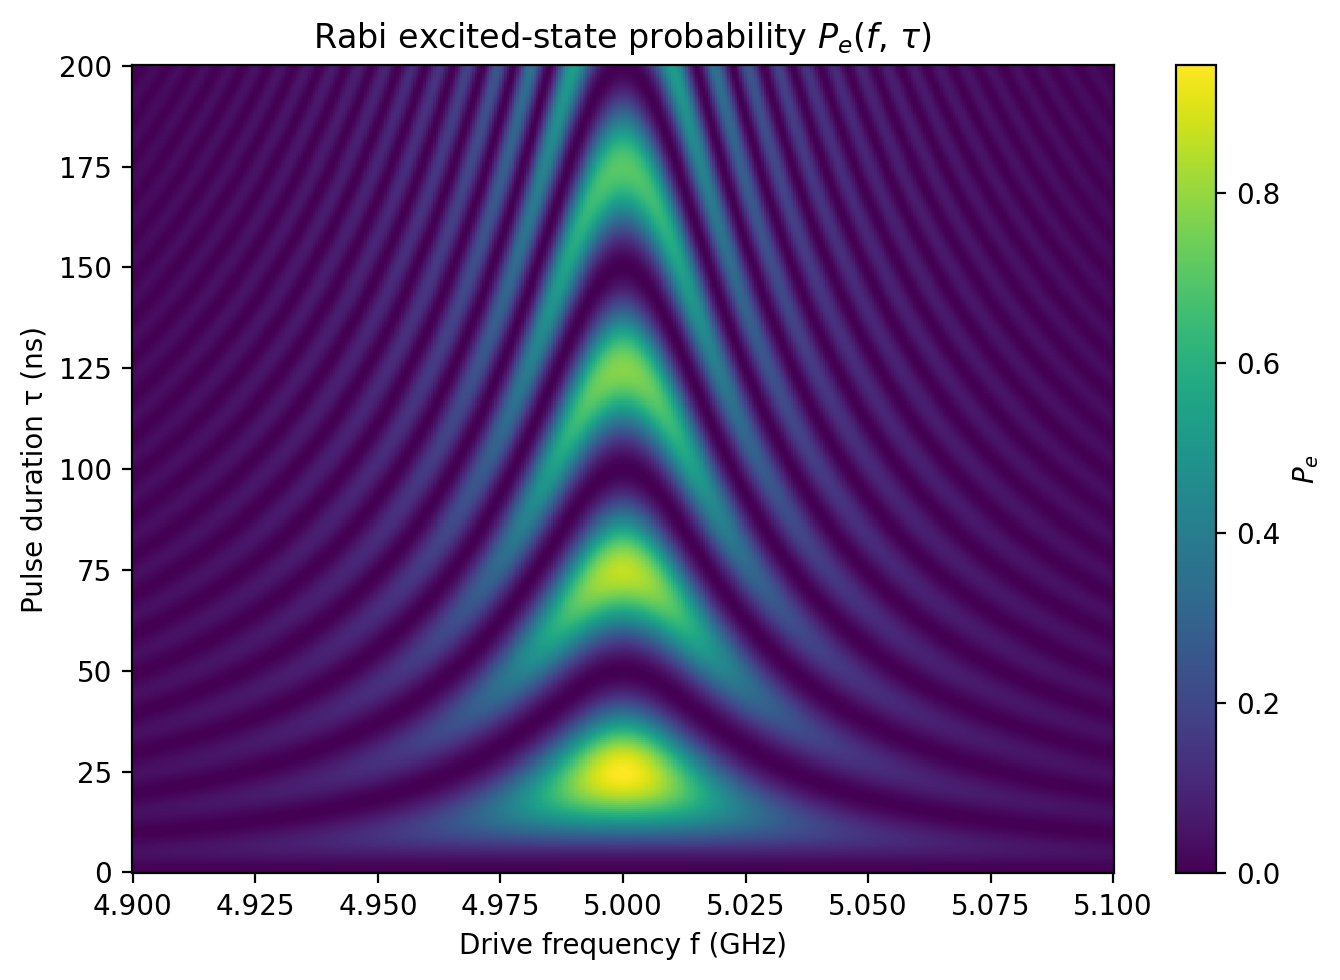

Saved: ./rabi_heatmap_2d.png


In [7]:
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.pcolormesh(freq_ghz, dur_ns, Pe, shading='auto')
cb = fig.colorbar(c, ax=ax, label=r'$P_e$')
ax.set_xlabel('Drive frequency f (GHz)')
ax.set_ylabel('Pulse duration τ (ns)')
ax.set_title('Rabi excited-state probability $P_e(f,\\,\\tau)$')
fig.tight_layout()
# fig.savefig(PNG_HEATMAP, dpi=300)
plt.show()
print('Saved:', PNG_HEATMAP)

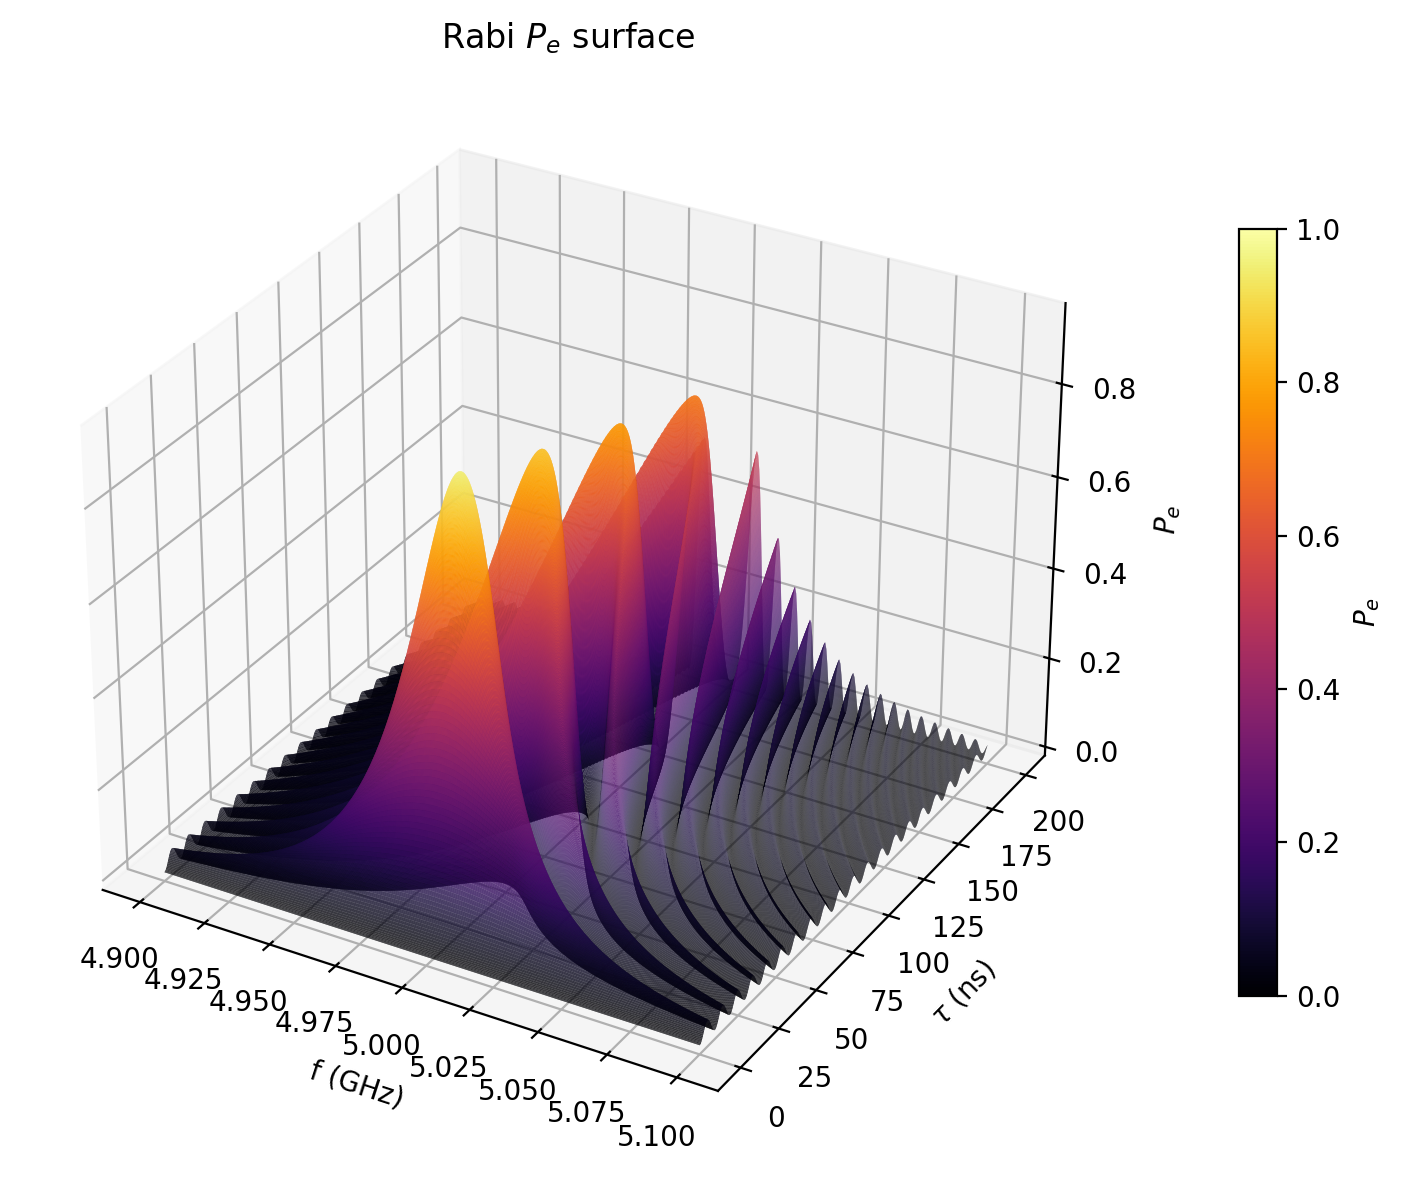

Saved: ./rabi_surface_3d_matplotlib.png


In [8]:
# --- High-res 3D surface with colormap & legend (Matplotlib) ---
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import numpy as np
import matplotlib.pyplot as plt

# Controls for surface quality and appearance
UPSAMPLE_FACTOR: int = 2           # 2=~4× more faces; try 3 for even smoother
SURFACE_CMAP: str = 'inferno'      # e.g., 'viridis', 'plasma', 'magma', 'inferno'
Z_MIN, Z_MAX = 0.0, 1.0            # clamp/normalize expected Pe range

# --- Bilinear upsampling (SciPy-free) ---
# 1) Upsample frequency axis for each fixed τ
freq_hi = np.linspace(freq_ghz.min(), freq_ghz.max(),
                      UPSAMPLE_FACTOR * (len(freq_ghz) - 1) + 1)
Pe_tau_f = np.empty((len(dur_ns), len(freq_hi)), dtype=float)
for i in range(len(dur_ns)):
    Pe_tau_f[i, :] = np.interp(freq_hi, freq_ghz, Pe[i, :])

# 2) Upsample τ axis for each fixed frequency
dur_hi = np.linspace(dur_ns.min(), dur_ns.max(),
                     UPSAMPLE_FACTOR * (len(dur_ns) - 1) + 1)
Pe_hi = np.empty((len(dur_hi), len(freq_hi)), dtype=float)
for j in range(len(freq_hi)):
    Pe_hi[:, j] = np.interp(dur_hi, dur_ns, Pe_tau_f[:, j])

# Mesh for plotting
F_hi, T_hi = np.meshgrid(freq_hi, dur_hi, indexing='xy')

# --- Plot ---
fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    F_hi, T_hi, Pe_hi,
    rstride=1, cstride=1,             # use every row/column (after upsampling)
    linewidth=0, antialiased=True,
    cmap=SURFACE_CMAP,
    vmin=Z_MIN, vmax=Z_MAX,
)

ax.set_xlabel('f (GHz)')
ax.set_ylabel(r'$\tau$ (ns)')
ax.set_zlabel(r'$P_e$')
ax.set_title('Rabi $P_e$ surface')

# Colorbar (legend for the colormap)
cb = fig.colorbar(surf, ax=ax, shrink=0.7, pad=0.08)
cb.set_label(r'$P_e$')

fig.tight_layout()
#fig.savefig(PNG_SURFACE, dpi=600)
plt.show()
print('Saved:', PNG_SURFACE)


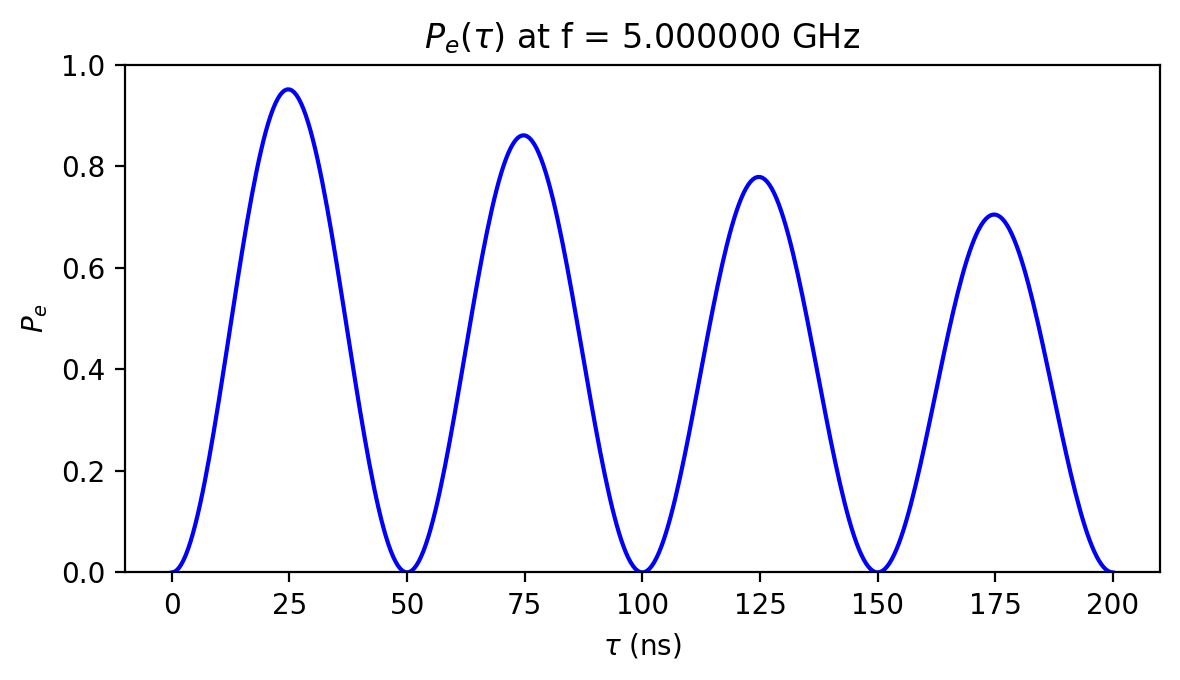

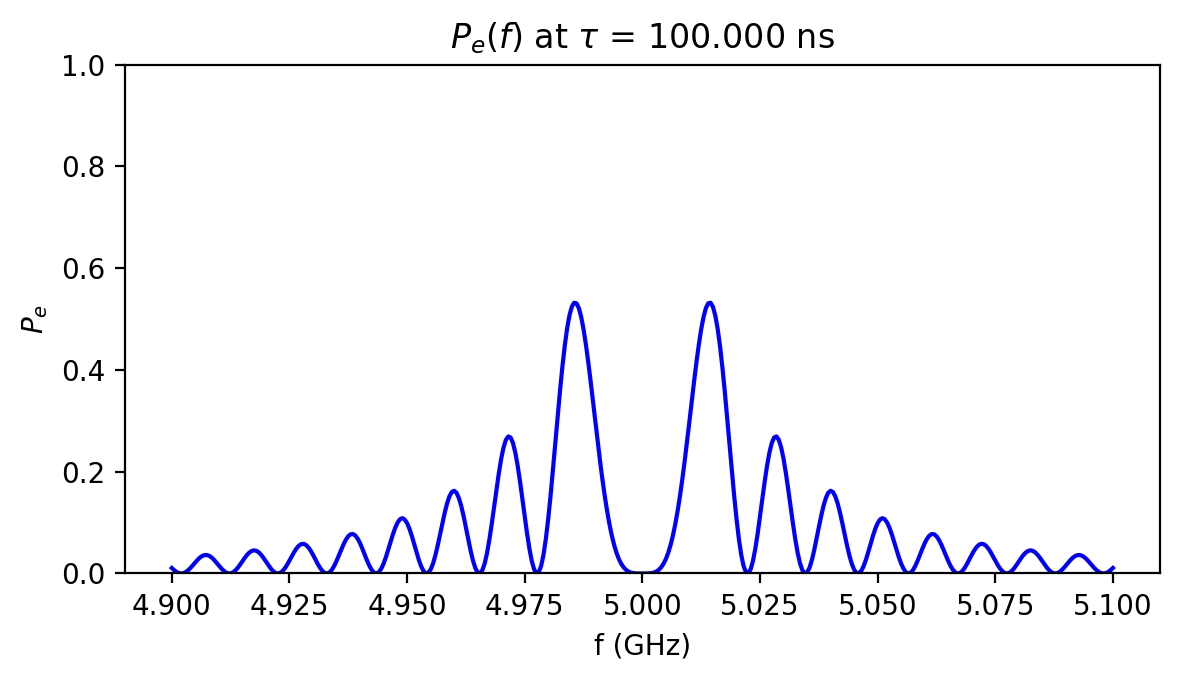

In [9]:
# @title Cross-sections
# Slicing controls
F_CROSS_GHZ: float = 5.000  # drive frequency slice [GHz]
T_CROSS_NS: float = 100.0   # duration slice [ns]

import numpy as np
import matplotlib.pyplot as plt

def _nearest_index(vec: np.ndarray, value: float, name: str) -> int:
    """Return nearest index to 'value' in 'vec'; clamp and notify if out of range."""
    vmin, vmax = float(vec.min()), float(vec.max())
    if value < vmin or value > vmax:
        print(f"[Note] {name}={value} is outside sweep; clamping to [{vmin}, {vmax}].")
        value = np.clip(value, vmin, vmax)
    return int(np.argmin(np.abs(vec - value)))

# --- Slice at f = F_CROSS_GHZ ---
j = _nearest_index(freq_ghz, F_CROSS_GHZ, "F_CROSS_GHZ")
Pe_vs_tau = Pe[:, j]

fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(dur_ns, Pe_vs_tau, color='blue')
ax.set_xlabel(r'$\tau$ (ns)')
ax.set_ylabel(r'$P_e$')
# Avoid \text{}; mix math for symbols and plain text for units/values
ax.set_title(r'$P_e(\tau)$ at f = ' + f'{freq_ghz[j]:.6f} GHz')
ax.set_ylim(0.0, 1.0)
fig.tight_layout()
plt.show()

# --- Slice at τ = T_CROSS_NS ---
i = _nearest_index(dur_ns, T_CROSS_NS, "T_CROSS_NS")
Pe_vs_f = Pe[i, :]

fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(freq_ghz, Pe_vs_f, color='blue')
ax.set_xlabel('f (GHz)')
ax.set_ylabel(r'$P_e$')
ax.set_title(r'$P_e(f)$ at $\tau$ = ' + f'{dur_ns[i]:.3f} ns')
ax.set_ylim(0.0, 1.0)
fig.tight_layout()
plt.show()


In [10]:
import csv
with open(CSV_OUT, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['freq_ghz', 'dur_ns', 'P_e'])
    for i_tau, tau in enumerate(dur_ns):
        for j_f, fghz in enumerate(freq_ghz):
            writer.writerow([fghz, tau, float(Pe[i_tau, j_f])])
print('Saved CSV:', CSV_OUT)

Saved CSV: ./rabi_grid_freq_duration.csv


In [11]:
# @title FFT of Rabi oscillations along τ (controls + computation)
import numpy as np
import matplotlib.pyplot as plt

# -------- Control knobs (FFT & display) --------
FFT_PAD: int = 8                 # zero-padding factor (2, 4, 8, ...)
WINDOW: str = "hann"             # "hann", "boxcar"
DETREND_MEAN: bool = True        # subtract mean along τ before FFT
AMP_MODE: str = "magnitude"      # "magnitude" | "power" | "db"
NORM_MODE: str = "global"        # "global" | "per_f" (column-wise)
FREQ_UNITS: str = "MHz"          # "MHz" or "GHz" for Fourier axis

# -------- Helpers --------
def _make_window(n: int, kind: str) -> np.ndarray:
    if kind.lower() == "hann":
        return np.hanning(n)
    return np.ones(n, dtype=float)  # boxcar

def rfft_spectrogram(
    Pe: np.ndarray,
    dur_ns: np.ndarray,
    pad: int = 8,
    window: str = "hann",
    detrend_mean: bool = True,
    amp_mode: str = "magnitude",
    norm_mode: str = "global",
    freq_units: str = "MHz",
) -> tuple[np.ndarray, np.ndarray]:
    """Compute RFFT along τ for each drive frequency column of Pe(τ, f).

    Args:
        Pe: array of shape (N_tau, N_f) with excited-state probabilities.
        dur_ns: τ grid [ns], length N_tau, evenly spaced.
        pad: zero-padding factor (≥1).
        window: "hann" or "boxcar".
        detrend_mean: subtract column-wise mean before FFT.
        amp_mode: "magnitude", "power", or "db".
        norm_mode: "global" (single max) or "per_f" (each column scaled to its max).
        freq_units: "MHz" or "GHz" for the Fourier axis.

    Returns:
        f_fft: Fourier frequency axis [MHz or GHz] (length N_w),
        S:     2D nonnegative spectrogram (N_w, N_f).
    """
    Pe = np.asarray(Pe, float)
    dur_ns = np.asarray(dur_ns, float)
    assert Pe.shape[0] == dur_ns.size, "Pe must be shaped (N_tau, N_f)."

    # Uniform sampling assumption (true for np.linspace)
    dt = float(dur_ns[1] - dur_ns[0]) * 1e-9               # [s]
    n_tau = dur_ns.size
    nfft = int(2 ** int(np.ceil(np.log2(n_tau))) * max(1, pad))
    w = _make_window(n_tau, window)

    # Prepare output
    S_list = []
    X = Pe.copy()
    if detrend_mean:
        X = X - X.mean(axis=0, keepdims=True)
    X *= w[:, None]

    # Real FFT along τ (axis=0)
    Xf = np.fft.rfft(X, n=nfft, axis=0)                     # shape (N_w, N_f)
    f_fft_hz = np.fft.rfftfreq(nfft, d=dt)                  # [Hz]

    # Amplitude selection
    if amp_mode.lower() == "power":
        S = np.abs(Xf) ** 2
    else:
        S = np.abs(Xf)

    # Normalization
    if norm_mode.lower() == "per_f":
        col_max = np.maximum(S.max(axis=0, keepdims=True), 1e-15)
        S = S / col_max
    else:
        S = S / max(S.max(), 1e-15)

    if amp_mode.lower() == "db":
        S = 20.0 * np.log10(np.maximum(S, 1e-12))  # dB, clipped floor

    # Units
    if freq_units.upper() == "GHz":
        f_fft = f_fft_hz * 1e-9
    else:
        f_fft = f_fft_hz * 1e-6

    return f_fft, S

# Compute spectrogram with current grid
f_fft_axis, S_fft = rfft_spectrogram(
    Pe, dur_ns,
    pad=FFT_PAD,
    window=WINDOW,
    detrend_mean=DETREND_MEAN,
    amp_mode=AMP_MODE,
    norm_mode=NORM_MODE,
    freq_units=FREQ_UNITS,
)
print("FFT grid:", S_fft.shape, "| Fourier freq range:", f_fft_axis[0], "→", f_fft_axis[-1], FREQ_UNITS)


FFT grid: (2049, 401) | Fourier freq range: 0.0 → 999.9999999999999 MHz


In [12]:
# @title Theoretical Rabi ridge (Ω_R/2π) for overlay
import math
two_pi = 2.0 * math.pi
f0 = F0_GHZ * 1e9
delta_hz = two_pi * (freq_ghz*1e9 - f0)   # rad/s detuning
omega_onres = two_pi * OMEGA_ONRESONANCE_MHZ * 1e6  # rad/s
Omega_R = np.sqrt(omega_onres**2 + delta_hz**2)     # rad/s
ridge_hz = Omega_R / (2.0 * math.pi)                # Hz
if FREQ_UNITS.upper() == "GHz":
    ridge_axis = ridge_hz * 1e-9
else:
    ridge_axis = ridge_hz * 1e-6  # MHz


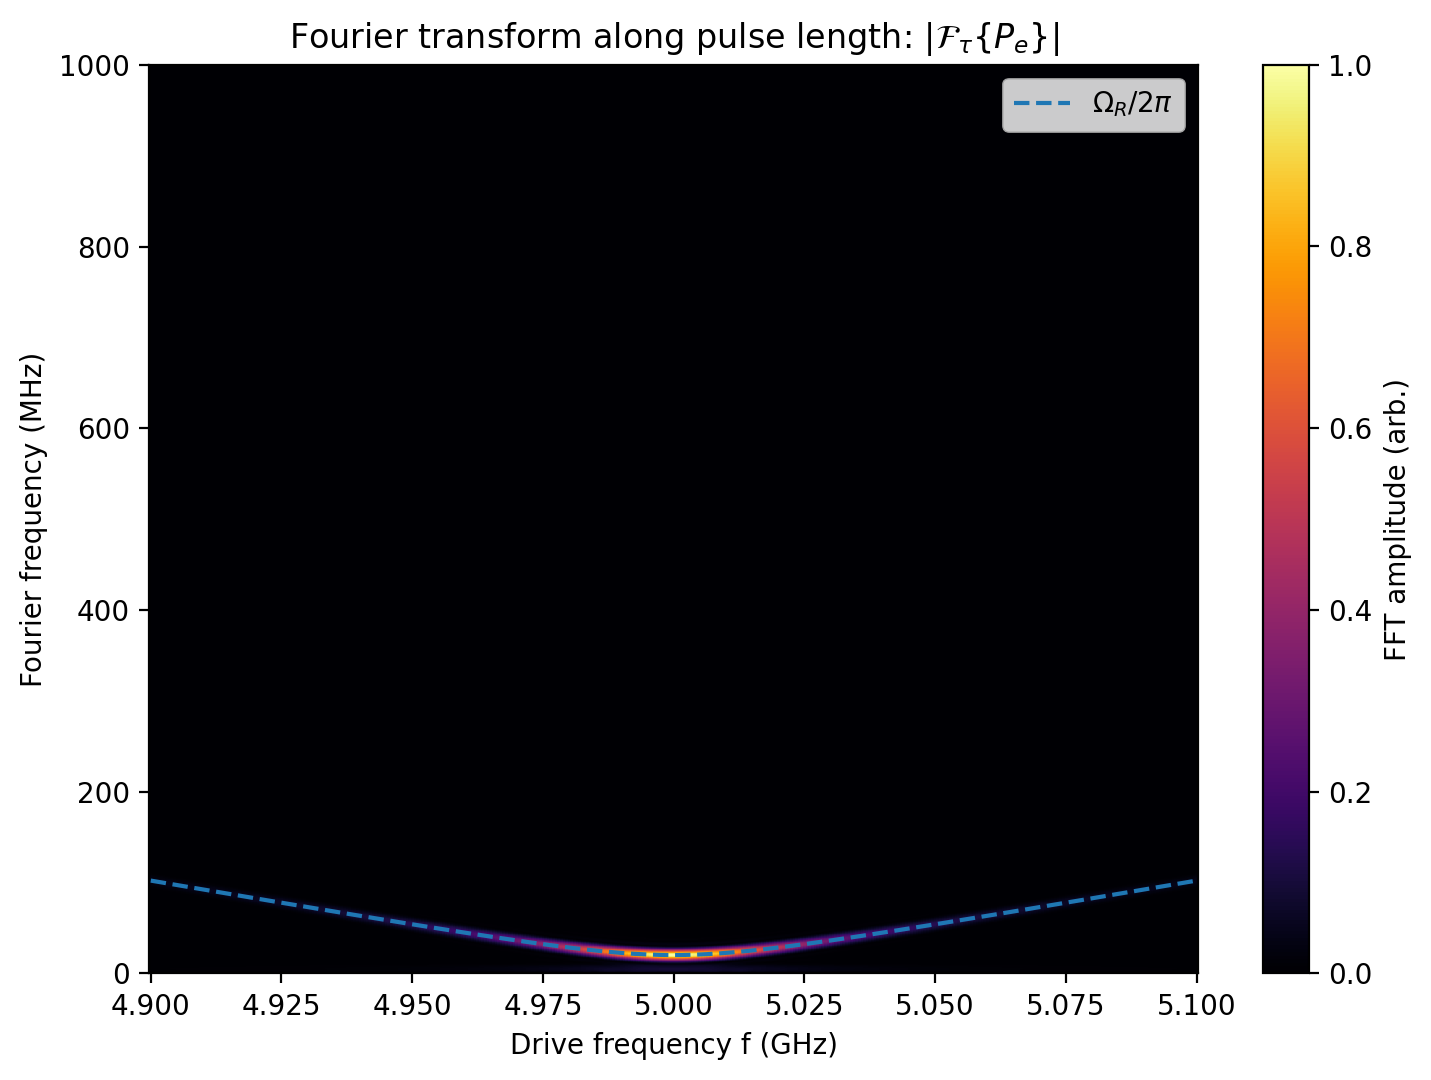

In [13]:
# @title 2D heatmap: |FFT{P_e(τ; f)}| vs (f, Fourier frequency)
fig, ax = plt.subplots(figsize=(7.5, 5.5))
im = ax.pcolormesh(freq_ghz, f_fft_axis, S_fft, shading="auto", cmap="inferno")
cb = fig.colorbar(im, ax=ax)
cb.set_label("FFT amplitude" + (" (dB)" if AMP_MODE.lower()=="db" else " (arb.)"))

ax.plot(freq_ghz, ridge_axis, "--", lw=1.5, label=r"$\Omega_R/2\pi$")
ax.set_xlabel("Drive frequency f (GHz)")
ax.set_ylabel(f"Fourier frequency ({FREQ_UNITS})")
ax.set_title("Fourier transform along pulse length: $|\\mathcal{F}_\\tau\\{P_e\\}|$")
ax.legend(loc="upper right")
fig.tight_layout()
# fig.savefig("rabi_fft_heatmap_2d.png", dpi=300)
plt.show()


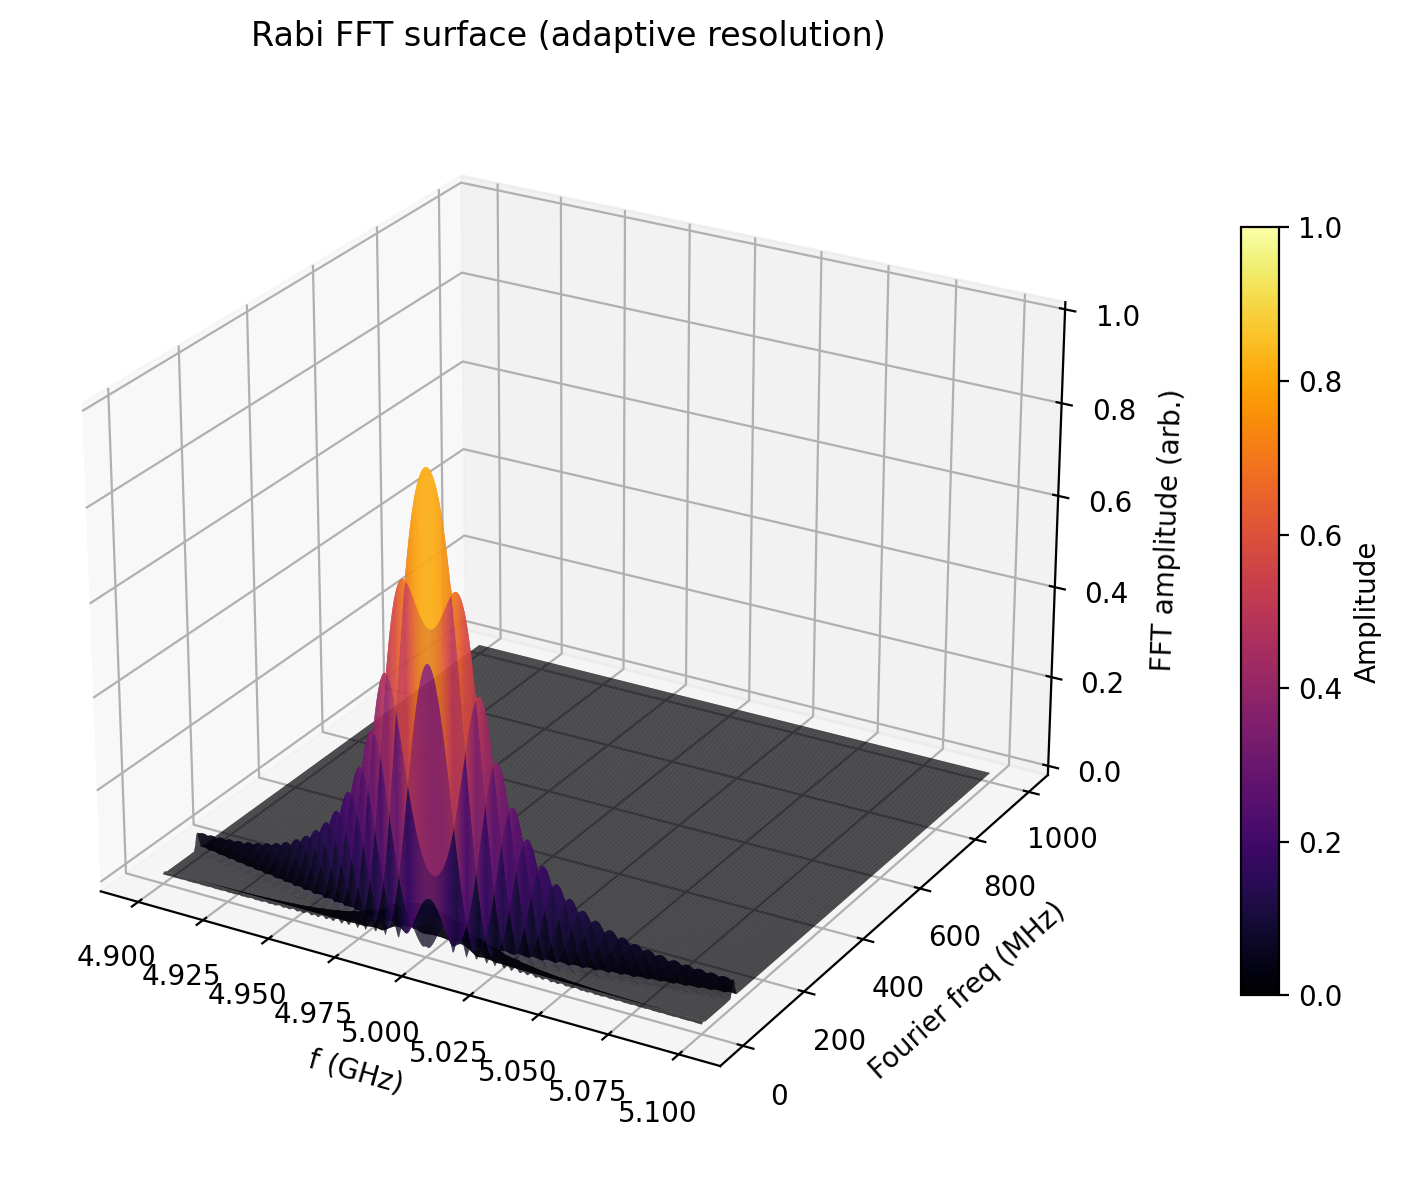

In [14]:
# --- Adaptive high-res 3D surface for |FFT{P_e(τ; f)}| (keeps 'inferno') ---
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import numpy as np
import matplotlib.pyplot as plt

# ------ Control knobs ------
UPSAMPLE_F_FREQ: int = 3       # try 2–3; upsample the drive-frequency axis only
MAX_FACES: int = 300_000       # cap on triangles to avoid OOM / crashes (≈300k–500k is OK)
MIN_ROWS: int = 128            # keep at least this many Fourier-frequency rows
MAX_ROWS: int = 1024           # hard cap for rows to keep plotting fast

# Preserve global color limits so the legend stays consistent
vmin = float(np.nanmin(S_fft))
vmax = float(np.nanmax(S_fft))

# Shapes
n_rows, n_cols = S_fft.shape        # rows=Fourier freq (ν), cols=drive freq (f)

# 1) Upsample along the typically smaller axis (drive frequency) only
n_cols_up = min(UPSAMPLE_F_FREQ * (n_cols - 1) + 1, 1200)  # sensible upper bound
freq_hi = np.linspace(freq_ghz.min(), freq_ghz.max(), n_cols_up)

S_up_f = np.empty((n_rows, n_cols_up), dtype=float)
for i in range(n_rows):
    S_up_f[i, :] = np.interp(freq_hi, freq_ghz, S_fft[i, :])

# 2) Determine how many Fourier rows we can afford for MAX_FACES
# faces ≈ (n_rows_plot-1) * (n_cols_up-1)
n_rows_cap = int(MAX_FACES / max(n_cols_up - 1, 1)) + 1
n_rows_plot = int(np.clip(n_rows_cap, MIN_ROWS, min(MAX_ROWS, n_rows)))

# Down-sample ν-axis evenly to n_rows_plot
row_idx = np.linspace(0, n_rows - 1, n_rows_plot).astype(int)
f_fft_plot = f_fft_axis[row_idx]
S_final = S_up_f[row_idx, :]

# Mesh for plotting
F2_hi, FFOUR_hi = np.meshgrid(freq_hi, f_fft_plot, indexing="xy")

# 3) Plot (keeps 'inferno')
fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    F2_hi, FFOUR_hi, S_final,
    rstride=1, cstride=1,
    linewidth=0, antialiased=True,
    cmap="inferno",
    vmin=vmin, vmax=vmax
)

ax.set_xlabel("f (GHz)")
ax.set_ylabel(f"Fourier freq ({FREQ_UNITS})")
ax.set_zlabel("FFT amplitude" + (" (dB)" if AMP_MODE.lower() == "db" else " (arb.)"))
ax.set_title("Rabi FFT surface (adaptive resolution)")
fig.colorbar(surf, ax=ax, shrink=0.7, pad=0.08, label="Amplitude")

# A clearer default view
ax.view_init(elev=25, azim=-60)

fig.tight_layout()
# fig.savefig("rabi_fft_surface_3d_adaptive.png", dpi=600)
plt.show()


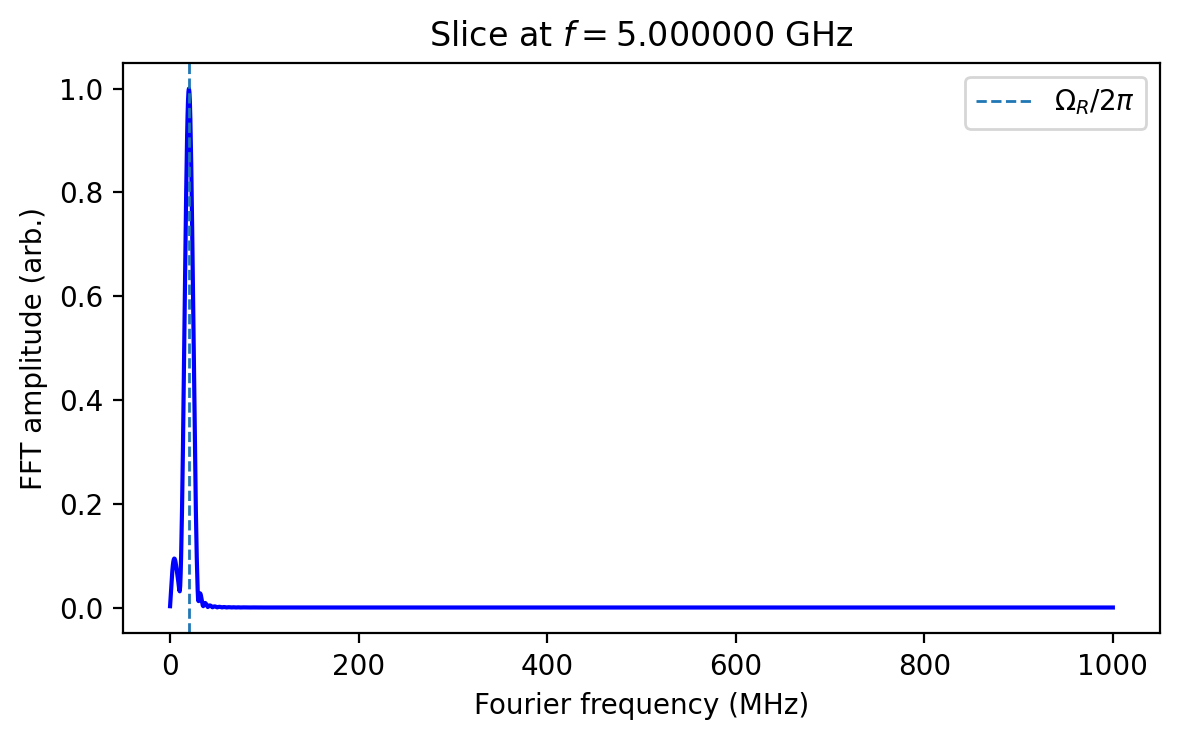

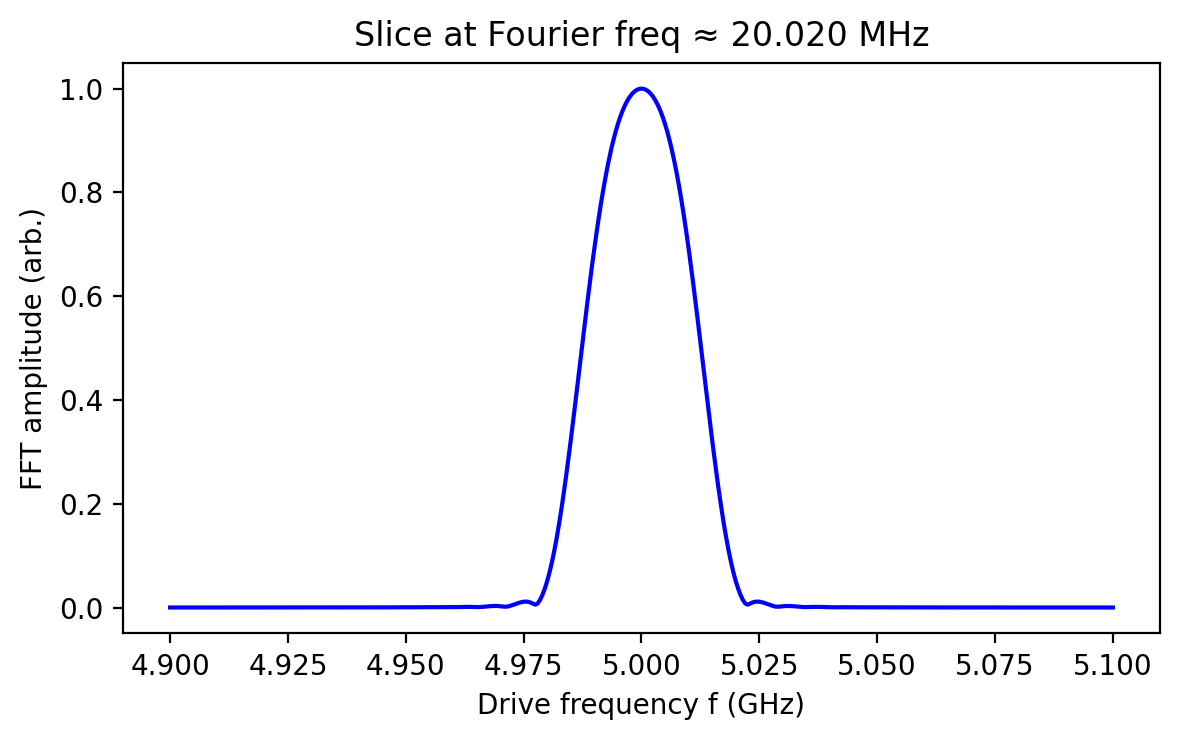

In [15]:
# @title Slices: amplitude vs Fourier freq (at f*) and vs f (at ν*)
F_STAR_GHZ: float = float(F0_GHZ)   # slice near resonance
NU_STAR = float(ridge_axis[np.argmin(np.abs(freq_ghz - F_STAR_GHZ))])  # near Ω_R/2π

# Slice at f = F_STAR_GHZ
j = int(np.argmin(np.abs(freq_ghz - F_STAR_GHZ)))
fig, ax = plt.subplots(figsize=(6.0, 3.8))
ax.plot(f_fft_axis, S_fft[:, j], color='blue')
ax.axvline(ridge_axis[j], ls="--", lw=1.0, label=r"$\Omega_R/2\pi$")
ax.set_xlabel(f"Fourier frequency ({FREQ_UNITS})")
ax.set_ylabel("FFT amplitude" + (" (dB)" if AMP_MODE.lower()=="db" else " (arb.)"))
ax.set_title(fr"Slice at $f={freq_ghz[j]:.6f}$ GHz")
ax.legend()
fig.tight_layout(); plt.show()

# Slice at ν = NU_STAR
i = int(np.argmin(np.abs(f_fft_axis - NU_STAR)))
fig, ax = plt.subplots(figsize=(6.0, 3.8))
ax.plot(freq_ghz, S_fft[i, :], color='blue')
ax.set_xlabel("Drive frequency f (GHz)")
ax.set_ylabel("FFT amplitude" + (" (dB)" if AMP_MODE.lower()=="db" else " (arb.)"))
ax.set_title(fr"Slice at Fourier freq ≈ {f_fft_axis[i]:.3f} {FREQ_UNITS}")
fig.tight_layout(); plt.show()
